The purpose of this notebook is to demonstrate the evolution of isomeric states under various conditions. An isomer is a nucleus in an excited state. Specifically, we focus on the meta-stable states as their $\beta$- decay rates are shorted than their ground state counter parts. Here we will focus on $^{85}Kr$ as it is a key branching point in s-process nucleosynthesis.

To start things off, we will check, install, and import the required packages to run the notebook. If you are running the notebook locally, the notebook will import the locally installed packages, and install the missing ones within the Jupyter server. It will not affect locally installed packages

In [2]:
#import the built-in python packages and check for the missing packages
import sys, subprocess,pkg_resources,io, requests
required = {'numpy','matplotlib','scipy','wnutils'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
#quietly install any missing packages. quietly simply means there will be no command line output
if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])
#import the numerical packages
import numpy as np
import wnutils.xml as wx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

Now that the environment is setup, let's get cracking. Here we import the reaction data necessary to calculate the appropriate reaction rates. We use an xml file that uses the JINA reaction rates we've uploaded to [OSF](https://osf.io/?utm_term=&utm_campaign=OSF+General&utm_source=adwords&utm_medium=ppc&hsa_acc=5222345373&hsa_cam=217339509&hsa_grp=60774351098&hsa_ad=295172720879&hsa_src=g&hsa_tgt=dsa-520694377169&hsa_kw=&hsa_mt=b&hsa_net=adwords&hsa_ver=3&gclid=CjwKCAiAvriMBhAuEiwA8Cs5lYszQLF5YP-ik42O5WdsO0RTy6rw4nl2ItD-q3ieZmQWsvpZU0TXLhoCwsEQAvD_BwE). You can also import a custom xml file as well. Simply place your xml file in the same directory as the notebook and replace everything in the outer most parenthesis with a string with the xml name and extension. To make your own custom xml, refer to the webnucelo notebooks found [here](https://webnucleo.readthedocs.io/en/latest/jupyter_notebooks.html).

In [3]:
#Importing the network data from OSF
xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/7463v/download').content))

Now that we have our reaction data, let's define our functions that will calculate the temperature profile which is based on user input, the reaction rates themselves, and the equilibrium mass fraction for the meta-stable state. It is worth noting that the ground to meta stable state is computed from the reverse rate in combination with the ground and isomeric ensemble partition functions

In [4]:
#Reaction rate calculator
def rate_calc(t9,ground,meta,reac_ex,reac_dec):
    nucs = xml.get_nuclide_data()

    Q = nucs[meta]['mass excess'] - nucs[ground]['mass excess']
    gg = nucs[ground]['partf']
    t9g = nucs[ground]['t9']
    gm = nucs[meta]['partf']
    t9m = nucs[meta]['t9']

    fg = interp1d(t9g, gg)
    fm = interp1d(t9m, gm)
    
    reacs = xml.get_reaction_data()
    reac = reacs[reac_dec]

    ex_rate = []
    dec_rate = []

    for t in t9:
        r = reac.compute_rate(t)
        dec_rate.append(r)
        ex_rate.append(r * (fm(t)/fg(t)) * np.exp(-11.605 * Q / t))

    return ex_rate,dec_rate
#Equilibrium mass fraction calculator
def meta_eq_mass_frac(t9,ground,meta,reac_ex,reac_dec):
    nucs = xml.get_nuclide_data()

    Q = nucs[meta]['mass excess'] - nucs[ground]['mass excess']
    gg = nucs[ground]['partf']
    t9g = nucs[ground]['t9']
    gm = nucs[meta]['partf']
    t9m = nucs[meta]['t9']

    fg = interp1d(t9g, gg)
    fm = interp1d(t9m, gm)

    return fm(t9)*np.exp(-11.605*Q/t9)/(fg(t9) + fm(t9)*np.exp(-11.605*Q/t9))

Other than reaction rates, we also need to define the scenario we are evolving our species under, and the species themselves; we are using $^{85}Kr$ and a custom oscillatory temperature profile that mimics [TP-AGB](https://en.wikipedia.org/wiki/Asymptotic_giant_branch) on a shorter time range. The species and reactions are to be introduced as strings, and the temperature profile should utilize python's 'bind' function. The cell below illustrates

In [5]:
#choose the species and set them as strings
nuclide_g = 'kr85g' #ground state
nuclide_m = 'kr85m' #meta-stable state

#set the reactions for excitation and decay
excite_string = nuclide_g + ' + gamma -> ' + nuclide_m
decay_string = nuclide_m + ' + gamma -> ' + nuclide_g

#initializing the time array in seconds since the rates are calculated in per seconds
t = np.linspace(0,100,1000)

'''Defining T9 as a sinusoidal function with an oscillation time scale of 10 sec
 for the sake of the example.
'''
t9 = 0.4*np.power((1 - 0.5*np.sin(2*np.pi*t/10)),1/3)

Now that the time and temperature are set, we can calculate the reaction rates and equilibrium mass fraction for the isomer state. We need the latter to help guide our understanding of the isomer mass fraction behavior.

In [6]:
#The reaction rates
lambda_excite, lambda_decay = rate_calc(t9,nuclide_g,nuclide_m,excite_string,decay_string)

#To view the reaction rate over a larger temperature scale, we include the graph here as well
#to act as a verifier that you are indeed using the rates you expect
t9s = np.logspace(-2,1)
lambda_ex_full, lambda_de_full = rate_calc(t9s,nuclide_g,nuclide_m,excite_string,decay_string)

Now we plot the temperature and rates. The top graph will show the reaction rates across the temperature range you want to evolve the system over, while the bottom one will show the reaction rates across a wider range.

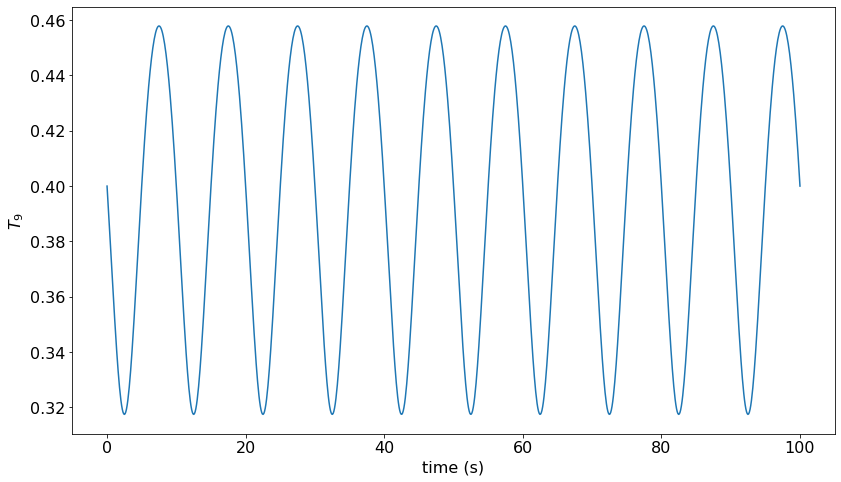

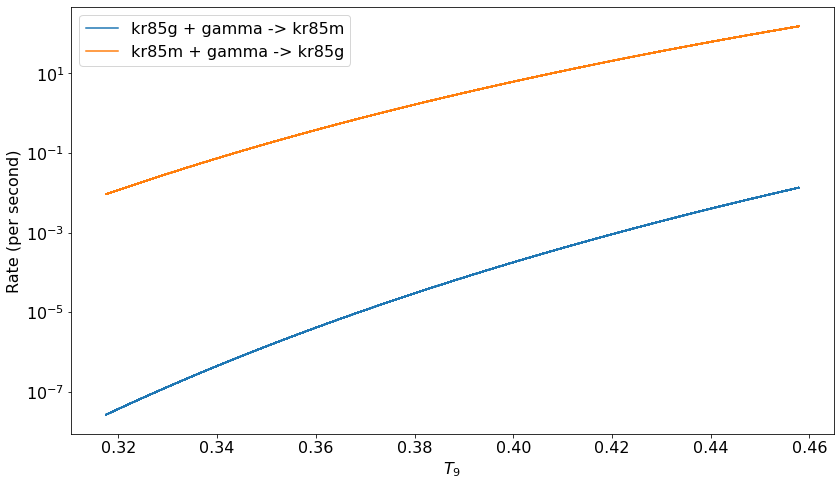

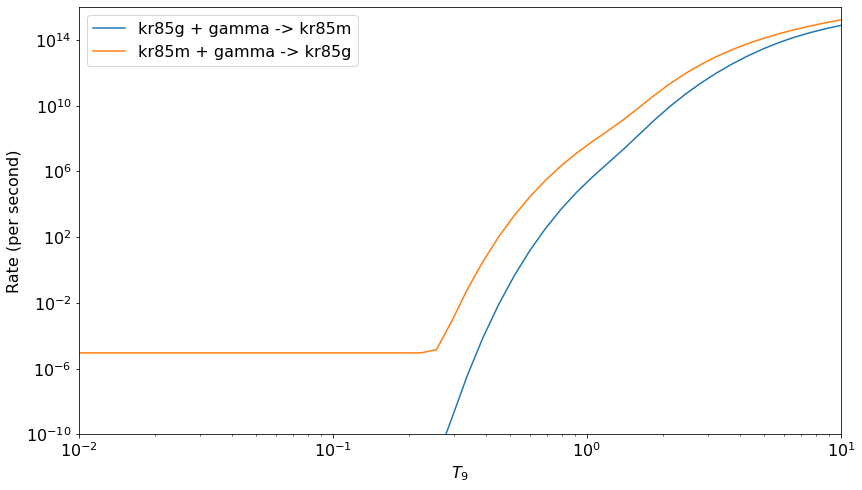

In [7]:
plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t,t9)
plt.xlabel('time (s)')
plt.ylabel(r'$T_{9}$')

plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t9,lambda_excite, label = excite_string)
plt.plot(t9,lambda_decay, label = decay_string)
plt.yscale('log')
plt.xlabel('$T_9$')
plt.ylabel('Rate (per second)')
plt.legend()

plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t9s,lambda_ex_full, label = excite_string)
plt.plot(t9s,lambda_de_full, label = decay_string)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.e-2, 10])
plt.ylim([1.e-10, 1.e16])
plt.xlabel('$T_9$')
plt.ylabel('Rate (per second)')
plt.legend()


plt.show()

Now that we've set the environment, it's time to prime the workhorse. The following is a simple two species network that solves the following system of equations using the Newton-Raphson solver:

$\begin{cases}
\frac{d x_{m}}{dt} = \lambda_{ground-meta} x_{g} - \lambda_{meta-ground} x_{m}\\
\frac{d x_{g}}{dt} = \lambda_{meta-ground} x_{m} - \lambda_{ground-meta} x_{g}
\end{cases}$

You can review a detailed derivation of the method [here](https://webnucleo.readthedocs.io/en/latest/jupyter_notebooks.html) under the Stellar Structure section.

In [8]:
#the followig 3 functions are for solving the 'network' via newton-raphson method 
def f1(y_85_m_dt,y_85_g_dt,y_85_m,dt,lambda_dec,lambda_ex):
    return y_85_m_dt*(1+lambda_dec*dt) - dt*lambda_ex*y_85_g_dt - y_85_m
    
def f2(y_85_m_dt,y_85_g_dt,y_85_g,dt,lambda_dec,lambda_ex):
    return y_85_g_dt*(1+dt*lambda_ex) - dt*lambda_dec*y_85_m_dt - y_85_g

def nef_raf_solver(lbda_ex,lbda_dec,t,y1,y2,y1_dt,y2_dt,y11,y22,tol):
    
    n_tot = len(t)
    for i in range(1,n_tot):
        delta = np.ones(2)
        dt = t[i] - t[i-1]
        A = np.array([[1 + lbda_dec[i]*dt, -dt*lbda_ex[i] ],[-lbda_dec[i]*dt, 1 + dt*lbda_ex[i]]])
        while (abs(max(delta)) > tol):
            b = np.array([-f1(y1_dt,y2_dt,y1,dt,lbda_dec[i],lbda_ex[i]),
            -f2(y1_dt,y2_dt,y2,dt,lbda_dec[i],lbda_ex[i])])
            delta = np.linalg.solve(A,b)
            y1_dt += delta[0]
            y2_dt += delta[1]
        y1 = y1_dt
        y2 = y2_dt
        
        y11 = np.append(y11,y1)
        y22 = np.append(y22,y2)

    return y11,y22

Now all that's left is to feed it a tolerance and initial conditions/guesses and get the evolution of the mass fractions for both states as a function of time. For the sake of convenience, we calculate the equilibrium mass fraction here as well.

In [9]:
#tolerance for Newton-Raphson solver to determine appropriate level of convergence
tol = 1e-6 

#at time 0
x_m = 0 #meta stable
x_g = 1 #ground state

#initial guess
x_m_dt = x_m
x_g_dt = x_g

#Calculating the mass fractions as time evolves
x_m,x_g = nef_raf_solver(lambda_excite,lambda_decay,t,x_m,x_g,x_m,x_g,x_m,x_g,tol)

#calculating the equilibrium mass fraction for the meta-stable state
x_m_eq = meta_eq_mass_frac(t9,nuclide_g,nuclide_m,excite_string,decay_string)

Here we graph the results

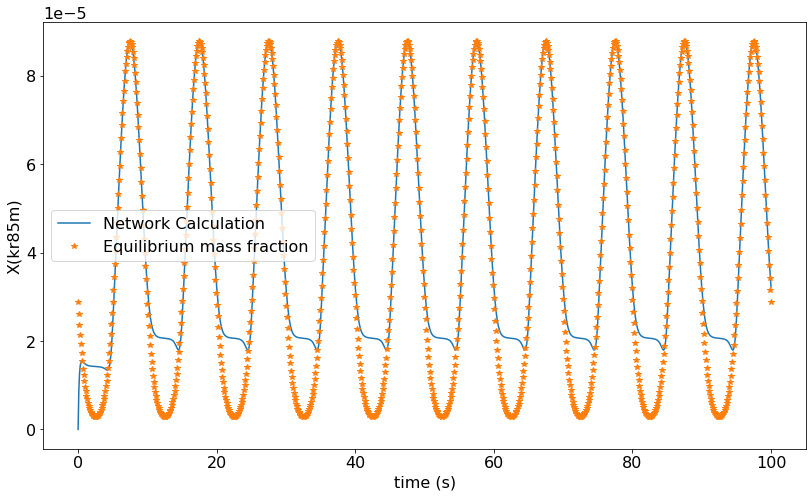

In [10]:
plt.figure(figsize=[13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t,x_m,label = 'Network Calculation')
plt.plot(t,x_m_eq,'*',label = 'Equilibrium mass fraction')
plt.xlabel('time (s)')
plt.ylabel('X('+nuclide_m+')')
plt.legend()

plt.show()

The graph above tells an interesting story, especially after the 1st peak. Ideally the mass fraction would like to tend to the equilibrium value, but as the temperature drops, the decay rate can't keep up, so it plateaus. As the temperature rises again, it catches up to it and is enough to keep up with it. Let's try a different example. We'll keep everything the same, but half the temperature, effectively shifting the reaction rates to a lower regime. The following cell will recalculate the rates for the new temperature range and graph the results of the mass fractions

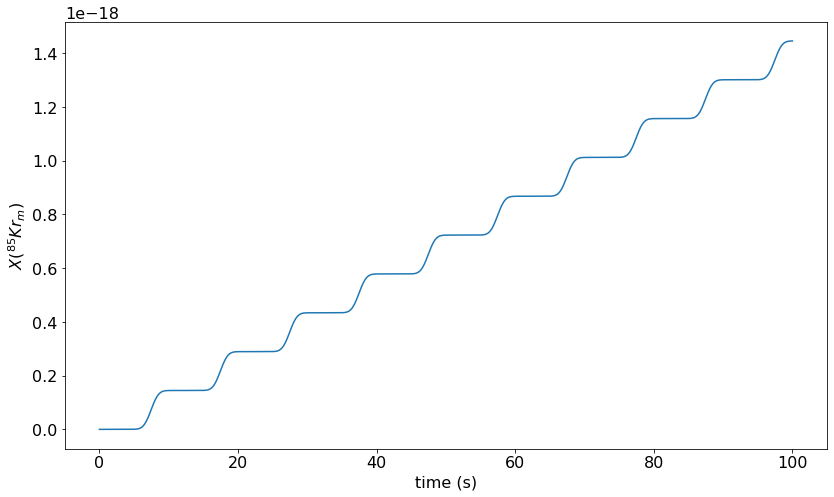

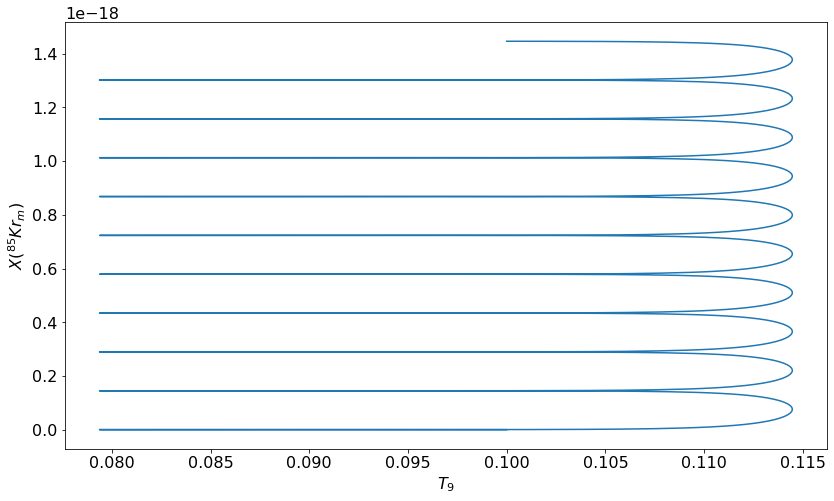

In [12]:
#setting the new temperature
t9 = 0.5*t9
#The reaction rates
lambda_excite, lambda_decay = rate_calc(t9,nuclide_g,nuclide_m,excite_string,decay_string)

#resetting the initial conditions and guess
x_m = 0 #meta stable
x_g = 1 #ground state
#initial guess
x_m_dt = x_m
x_g_dt = x_g
#Calculating the mass fractions as time evolves
x_m,x_g = nef_raf_solver(lambda_excite,lambda_decay,t,x_m,x_g,x_m,x_g,x_m,x_g,tol)

plt.figure(figsize = [13.66,7.86])
plt.rcParams['font.size'] = 16
plt.plot(t,x_m)
plt.xlabel('time (s)')
plt.ylabel(r'$X(^{85}Kr_m)$')

plt.figure(figsize = [13.66,7.86])
plt.plot(t9,x_m)
plt.xlabel(r'$T_{9}$')
plt.ylabel(r'$X(^{85}Kr_m)$')

plt.show()

By simply halfing the temperature, the evolution of the meta stable mass fractions goes from an oscillatory regime to a pumping regime. Since the decay rate is relatively low and the system is almost completely in the ground state, so what little meta stable isomers form do not decay as the temperature drops despite the reaction rate for decay is higher than that of excitation (refer to rate graph a few cells up). Then as the temperature rises, new isomers form, leading to a pumping effect.

If the user wishes to use the predefined functions in the cell above and not jump around the notebook to test their own rates and temperature profile, simply uncomment the below cell , which has a preset example you can follow', change what you will, add you own rate calculator if need be and the rest is simply a push of a button.

In [ ]:
'''
xml = wx.Xml('my_test_network.xml') #you can change the string to reflect the actual name of your file
t = np.logspace(-14,2,1000)
t9 = 1.0*np.ones(len(t))

#choose the species and set them as strings
nuclide_g = 'kr85g' #ground state
nuclide_m = 'kr85m' #meta-stable state

#set the reactions for excitation and decay
excite_string = nuclide_g + ' + gamma -> ' + nuclide_m
decay_string = nuclide_m + ' + gamma -> ' + nuclide_g

lambda_excite, lambda_decay = rate_calc(t9,nuclide_g,nuclide_m,excite_string,decay_string)

#at time 0
x_m = 0
x_g = 1
#initial guess
x_m_dt = x_m
x_g_dt = x_g

x_m,x_g = nef_raf_solver(lambda_excite,lambda_decay,t,x_m,x_g,x_m,x_g,x_m,x_g,tol)

#calculating the equilibrium mass fraction for the meta-stable state
x_m_eq = meta_eq_mass_frac(t9,nuclide_g,nuclide_m,excite_string,decay_string)

plt.figure(figsize=[13.66,7.86])
plt.plot(t,x_m_eq,'*',label = 'equilibrium')
plt.plot(t,x_m,label = 'Network')
plt.xscale('log')
plt.legend()
plt.show()
'''